In [1]:
import numpy as np
import pandas as pd
from urllib.request import urlopen
from bs4 import BeautifulSoup
import time

C:\Users\cpilo\Hello\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#Here we will we looking at a way we can use the stanford NER Tagger to help improve the afinn sentiment analysis algorithm.
#The afinn algorithm scores text by scanning and checking for words in the afinn lexicon. This algorithm works best on 
#smaller segments of text so we will score the article at the sentence level. In this example I will grade the sentiment
#of the Baltimore Ravens and the Houston Texans.
url = 'https://www.forbes.com/betting/nfl/texans-ravens-week-1-23/'
html = urlopen(url)
soup = BeautifulSoup(html)

In [3]:
x = soup.getText().split('Betting Matchup Preview')[1]
x1 = x.split('\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n')[0]
x1 = x1.replace('\n', '')
sentence_split = x1.split('.')
sentence_split

['Game DetailsWho: Houston Texans at Baltimore RavensWhen: Thursday, Sep',
 ' 10 (Week 1)Time: 1:00 p',
 'm',
 ' ETWhere: M&T Bank Stadium (Baltimore, MD)Betting Odds SummarySpread: Texans +9 (-110), Ravens -9 (-110)Moneyline: Texans +330, Ravens -410Total: Over/Under 44',
 '5 (-110/-110)Note: Odds from DraftKings Sportsbook',
 ' Subject to change',
 'The Baltimore Ravens will kick off their quest for a Super Bowl championship at home in Week 1 against the Houston Texans',
 ' Kickoff from M&T Bank Stadium is scheduled for 1:00 p',
 'm',
 ' ET and can be seen on CBS',
 'Baltimore drew a good card from the NFL’s schedule makers by receiving Houston to begin the season',
 ' The Texans are expected to be one of the worst teams in the league again as they begin their rebuild under new head coach DeMeco Ryans',
 '\xa0Every major offseason storyline for the Ravens revolved around quarterback Lamar Jackson',
 ' Jackson entered free agency following the conclusion of the 2022 season, and his de

In [4]:
#import StanfordNERTagger
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
import nltk
import os
java_path = r"C:\Program Files\Java\jdk1.8.0_152\bin\java.exe"
os.environ['JAVAHOME'] = java_path
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cpilo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
PATH_TO_JAR=r"C:\Users\cpilo\Downloads\stanford-ner-4.2.0\stanford-ner-2020-11-17\stanford-ner-4.2.0.jar"
PATH_TO_MODEL = r"C:\Users\cpilo\Downloads\stanford-ner-4.2.0\stanford-ner-2020-11-17\classifiers\english.all.3class.distsim.crf.ser.gz"
st = StanfordNERTagger(PATH_TO_MODEL,
                       PATH_TO_JAR,
                       encoding='utf-8')


In [6]:
#We import our afinn function to score our sentences
from afinn import Afinn
afn = Afinn()

In [7]:
ner_objects = []
score = [afn.score(i) for i in sentence_split]
for i in range(len(sentence_split)):
    sentence_subj = []
    token_text = word_tokenize(sentence_split[i])
    class_text = st.tag(token_text)
    #iterate through the classified text
    for (x,y) in class_text:
        #We are looking at sentences with organizations referring to the texans or ravens
        #The tagger should allow us to distiguish between times when Houston/Baltimore refers to the city vs when it refers
        #to the organization
        if x in ['Ravens', 'Baltimore', 'Houston', 'Texans'] and y == 'ORGANIZATION':
            sentence_subj.append(x)
    ner_objects.append([sentence_subj, score[i], sentence_split[i]])
article_df = pd.DataFrame(ner_objects, columns = ['Subject', 'Score', 'Sentence'])
article_df

,Subject,Score,Sentence
0,"[Houston, Texans]",0.0,Game DetailsWho: Houston Texans at Baltimore R...
1,[],0.0,10 (Week 1)Time: 1:00 p
2,[],0.0,m
3,[Ravens],0.0,"ETWhere: M&T Bank Stadium (Baltimore, MD)Bett..."
4,[],0.0,5 (-110/-110)Note: Odds from DraftKings Sports...
...,...,...,...
60,[],3.0,If Stroud looks good and appears ready for th...
61,[],-2.0,"If he struggles and looks overmatched, howeve..."
62,[Ravens],1.0,"Either way, the odds for this game are unlikel..."
63,[],2.0,We may see some minor shifts in either direct...


In [8]:
#We can create a state matrix that will have the teams score for each sentence in the article
org_state = pd.DataFrame(columns = ['Baltimore Ravens', 'Houston Texans'], index = np.array(range(len(article_df.index)))).fillna(0)
for i in org_state.index:
    if 'Ravens' in article_df['Subject'][i] or 'Baltimore' in article_df['Subject'][i]:
        org_state['Baltimore Ravens'][i] = article_df['Score'][i]
    elif 'Houston' in article_df['Subject'][i] or 'Texans' in article_df['Subject'][i]:
        org_state['Houston Texans'][i] = article_df['Score'][i]
org_state

,Baltimore Ravens,Houston Texans
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
60,0,0
61,0,0
62,1,0
63,0,0


In [9]:
#Sum to get our team sentiment scores
print('Ravens Sentiment: ', np.sum(org_state['Baltimore Ravens']), '  Texans Sentiment: ', np.sum(org_state['Houston Texans']))

Ravens Sentiment:  21   Texans Sentiment:  0


In [10]:
#The cumulative sum can allow us to evaluate the sentiment of each subject as a time series throughout the article
sentiment_progression = org_state.cumsum()
sentiment_progression

,Baltimore Ravens,Houston Texans
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
60,20,0
61,20,0
62,21,0
63,21,0


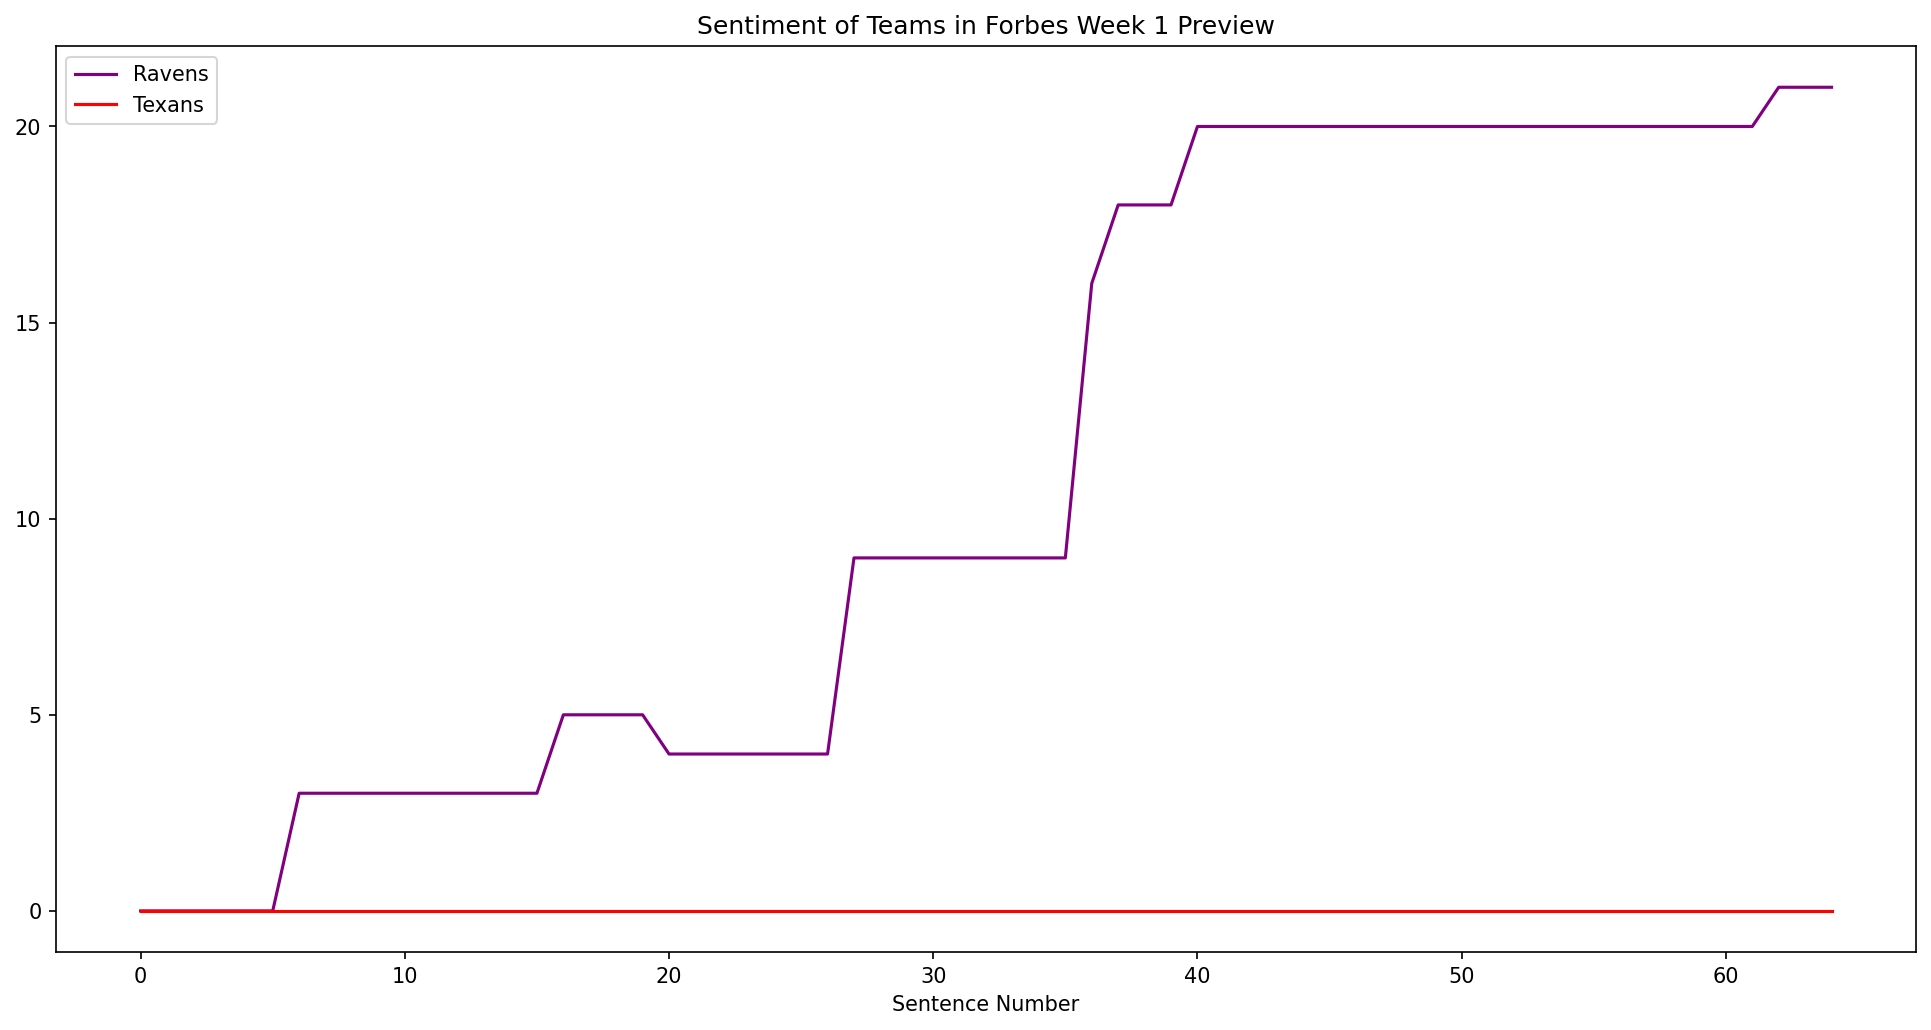

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8), dpi=150)
  
#plot our ravens and texans time series sentiment scores
sentiment_progression['Baltimore Ravens'].plot(label='Ravens', color='purple')
sentiment_progression['Houston Texans'].plot(label='Texans', color = 'red')
plt.title('Sentiment of Teams in Forbes Week 1 Preview')
plt.xlabel('Sentence Number')
plt.legend()